In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss


gamma_0 = 1.30905513329
gamma_1 = 0.472008228977

def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

def link_function_rev(y):
    return -((gamma_0 * y) / (gamma_1 * y - gamma_1 - gamma_0 * y))

def get_mean_val(models):
    return np.mean([model.booster().best_score for model in models])

/home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def load_features(data_type, features, typ="clean"):
    
    data_feat = []
    id_col = 'id'
    if data_type == 'test':
        id_col = 'test_id'
    for feature in features:
        try:
            feat = pd.read_csv('features/{}_{}_{}.csv'.format(typ, data_type, feature),index_col=id_col)
        except:
            feat = pd.read_csv('features/{}_{}_{}.csv'.format(typ, data_type, feature))
        cols = list(feat.columns)
        feat.columns = list(map(lambda x: feature+x,cols))
        data_feat.append(feat)
        
    return pd.concat(data_feat,axis=1)

In [18]:
clean_train_features = load_features('train', ['distance',
                                               'word_share_features', 
                                               'gensim_sent_features', 
                                               'error_features',
                                               'lstm_glove_features'])

magic_features = load_features('train',['magic_features_graph',
                                        'magic_features_kcore',
                                        'magic_features_wm',
                                        'locations'], typ='raw')

stem_train_features = load_features('train', ['tfidf_lsa_50_features'], typ='stem')

lem_train_features = load_features('train', ['word_pos_features'], typ='lem')

train_features = pd.concat([clean_train_features, 
                            stem_train_features, 
                            lem_train_features, 
                            magic_features , train_ab], axis=1)

train_features = train_features.replace([np.inf, -np.inf], np.nan)
train_features = train_features.fillna(0)

train_data = pd.read_csv('data/train.csv', index_col='id')
train_data = train_data.fillna("")
train_data.shape

train_features['is_duplicate'] = train_data['is_duplicate']

In [21]:
train_features.shape

(404290, 156)

In [20]:
X_train, y_train = train_features.drop('is_duplicate',axis=1),  train_features['is_duplicate']

xgb_params = {
    'max_depth': 5, 
    'learning_rate': 0.085,
    'n_estimators': 1000, 
    'objective': 'binary:logistic',
    'nthread': 8, 
    'gamma': 0, 
    'subsample': 0.75, 
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 1,
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1
}

bst = xgb.XGBClassifier(silent=False).set_params(**xgb_params)

bst = bst.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train)], 
                      eval_metric='logloss',
                      verbose=10)

[0]	validation_0-logloss:0.640794
[10]	validation_0-logloss:0.382378
[20]	validation_0-logloss:0.300598
[30]	validation_0-logloss:0.268592
[40]	validation_0-logloss:0.253745
[50]	validation_0-logloss:0.244936
[60]	validation_0-logloss:0.238811
[70]	validation_0-logloss:0.234813
[80]	validation_0-logloss:0.231887
[90]	validation_0-logloss:0.228912
[100]	validation_0-logloss:0.226585
[110]	validation_0-logloss:0.224541
[120]	validation_0-logloss:0.223089
[130]	validation_0-logloss:0.221556
[140]	validation_0-logloss:0.220302
[150]	validation_0-logloss:0.218992
[160]	validation_0-logloss:0.21774
[170]	validation_0-logloss:0.216581
[180]	validation_0-logloss:0.215565
[190]	validation_0-logloss:0.214549
[200]	validation_0-logloss:0.213588
[210]	validation_0-logloss:0.212687
[220]	validation_0-logloss:0.211792
[230]	validation_0-logloss:0.21087
[240]	validation_0-logloss:0.210043
[250]	validation_0-logloss:0.209354
[260]	validation_0-logloss:0.208582
[270]	validation_0-logloss:0.207841
[280]

In [22]:
print('ok')

ok


In [27]:
clean_test_features = load_features('test', ['distance',
                                             'word_share_features',
                                             'gensim_sent_features',
                                             'lstm_glove_features'])

magic_test_features = load_features('test', ['magic_features_freq',
                                             'magic_features_graph', 
                                             'magic_features_graph_cc',
                                             'magic_features_kcore',
                                             'magic_features_wm',
                                             'magic_features_pr',
                                             'locations'], typ='raw')

stem_test_features = load_features('test', ['tfidf_lsa_50_features'], typ='stem')

lem_test_features = load_features('test', ['word_pos_features'], typ='lem')

test_features = pd.concat([clean_test_features, stem_test_features, 
                           lem_test_features, magic_test_features], axis=1)

test_features = test_features.replace([np.inf, -np.inf], np.nan)
test_features = test_features.fillna(0)

In [28]:
test_features.shape

(2345796, 155)

In [29]:
print('Building Submission')
sub = pd.DataFrame()
sub['test_id'] = test_features.index
sub['is_duplicate'] = link_function(bst.predict_proba(test_features)[:, 1])
sub.to_csv('submissions/new_06_06_02.csv',index=None)

Building Submission


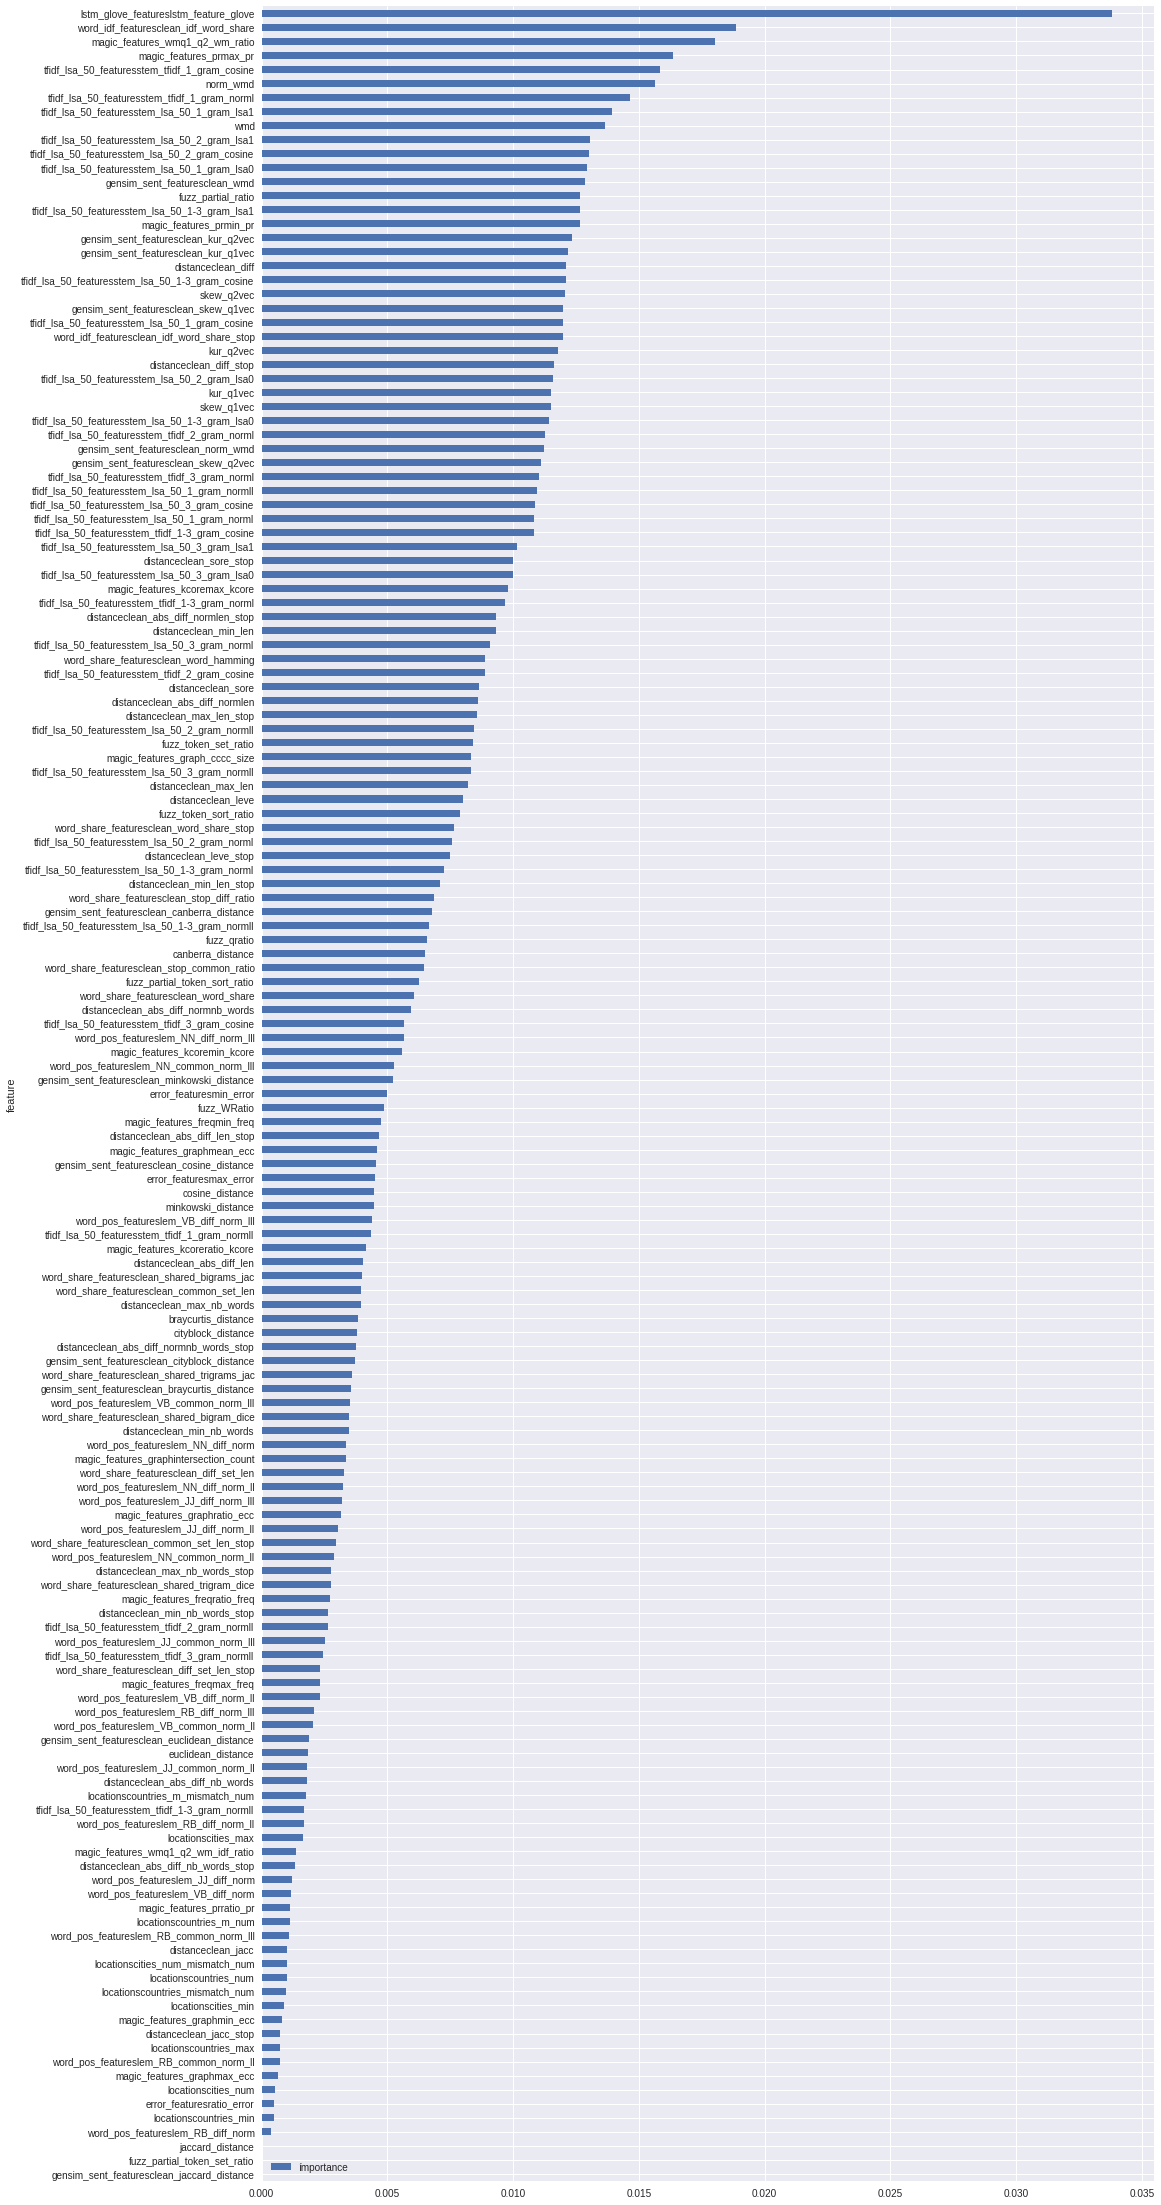

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
ip = bst.feature_importances_
cols = train_features.columns[:-1]
fi = pd.DataFrame([(cols[i],ip[i]) for i in range(len(cols))], columns=['feature','ímportance'])
fi = fi.sort_values(fi.columns[1],ascending=True).reset_index()
fi.plot(kind='barh',x='feature',y='ímportance',figsize=(16,40),sort_columns=True)